In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 导入训练集和测试集，分成 特征X 和 目标Y

In [105]:
df_train=pd.read_csv('df_train.csv',index_col=0)
df_test=pd.read_csv('df_test.csv',index_col=0)

In [106]:
Xtrain=df_train.loc[:,df_train.columns!='status']
Ytrain=df_train.loc[:,'status']

Xtest=df_test.loc[:,df_test.columns!='status']
Ytest=df_test.loc[:,'status']

In [107]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(3327, 87)
(3327,)
(1427, 87)
(1427,)


In [108]:
Xtrain.head()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,reg_preference_for_trad_一线城市,reg_preference_for_trad_三线城市,reg_preference_for_trad_二线城市,reg_preference_for_trad_其他城市,reg_preference_for_trad_境外
296,0.01,0.99,4000,0.96,1.00,0.405,16.0,29.0,28.0,1.0,...,7.0,15600.0,8228.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0
8545,0.03,0.97,500,0.87,1.00,0.205,18.0,27.0,27.0,3.0,...,5.0,21600.0,7160.0,30.0,27.0,1.0,0.0,0.0,0.0,0.0
7641,0.02,0.86,0,1.98,0.70,0.205,18.0,53.0,33.0,2.0,...,5.0,13800.0,10320.0,3.0,137.0,1.0,0.0,0.0,0.0,0.0
1193,0.02,0.81,1000,1.49,0.73,0.555,23.0,15.0,8.0,4.0,...,12.0,17400.0,6418.0,20.0,51.0,0.0,1.0,0.0,0.0,0.0
10,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,...,6.0,22800.0,9360.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0


## 1.无量纲化----标准化StandardScaler

In [109]:
from sklearn.preprocessing import StandardScaler

In [110]:
scaler=StandardScaler().fit(Xtrain)

In [111]:
Xtrain_scaler=scaler.transform(Xtrain)
Xtest_scaler=scaler.transform(Xtest)

In [112]:
Xtrain_scaler.shape

(3327, 87)

## 2.特征选择-随机森林法

In [203]:
from sklearn.ensemble import RandomForestClassifier

In [204]:
RFC=RandomForestClassifier(n_estimators=1000).fit(Xtrain_scaler,Ytrain)

In [205]:
importance=RFC.feature_importances_   # 看一下每一个特征的重要性

In [206]:
importance_data = pd.DataFrame({'columns':Xtrain.columns,'importance':importance}).sort_values("importance",ascending=False)

In [207]:
importance_data.head(7)

,columns,importance
29,trans_fail_top_count_enum_last_1_month,0.051324
63,history_fail_fee,0.047048
51,loans_score,0.036418
41,apply_score,0.029030
55,loans_overdue_count,0.024752
65,latest_one_month_fail,0.022897
18,trans_amount_3_month,0.017039


In [220]:
score1=[]
for i in [0,0.001,0.005,0.01]:
    Xtrain_rfc=Xtrain_scaler[:,importance_data[importance_data['importance']>=i].index]
    Xtest_rfc=Xtest_scaler[:,importance_data[importance_data['importance']>=i].index]
    rfc1=RandomForestClassifier(n_estimators=1000).fit(Xtrain_rfc,Ytrain)
    score1.append(rfc1.score(Xtest_rfc,Ytest))
    
print(score1)

[0.7841625788367204, 0.7876664330763841, 0.7813594954449895, 0.7834618079887876]


In [230]:
# 准确率貌似降低，下次用 roc曲线来确定，本次保持不变。

## 3.特征过滤----方差过滤+相关性过滤

#### 方差过滤

In [241]:
from sklearn.feature_selection import VarianceThreshold   

In [242]:
selector=VarianceThreshold().fit(Xtrain_scaler)   #删除方差为0的特征，因为之前预处理貌似已经删除了，估计这里没有

In [243]:
Xtrain_variance=selector.transform(Xtrain_scaler)
Xtest_variance=selector.transform(Xtest_scaler)

In [244]:
print(Xtrain_variance.shape)
print(Xtest_variance.shape)

(3327, 87)
(1427, 87)


#### 互信息法

In [245]:
from sklearn.feature_selection import mutual_info_classif as MIC

In [246]:
result = MIC(Xtrain_variance,Ytrain)

In [247]:
k = result.shape[0] - sum(result <= 0)
k

57

In [248]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest

In [249]:
X_fsmic = SelectKBest(MIC, k).fit_transform(Xtrain_variance, Ytrain)
cross_val_score(RFC(n_estimators=500,random_state=0),X_fsmic,Ytrain,cv=5).mean()

0.7977202544513895

In [250]:
# 看到模型的准确率上升，可以选择这 57 个特征

In [258]:
MIC1 = SelectKBest(MIC, k).fit(Xtrain_variance, Ytrain)

In [259]:
Xtrain_MIC1=MIC1.transform(Xtrain_variance)

In [260]:
Xtest_MIC1=MIC1.transform(Xtest_variance)

In [261]:
Xtrain_MIC1.shape

(3327, 57)

In [262]:
Xtest_MIC1.shape

(1427, 57)

In [263]:
Ytrain.shape

(3327,)

In [264]:
Ytest.shape

(1427,)

## 降维PCA 

In [265]:
from sklearn.decomposition import PCA

In [266]:
pca=

In [269]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (4,) and (57,)

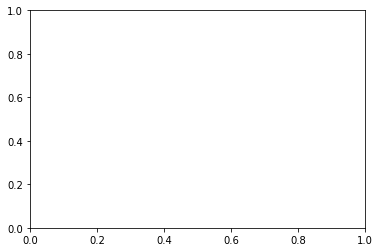

In [270]:
import numpy as np
pca_line = PCA().fit(Xtrain_MIC1)
plt.plot([1,2,3,4],np.cumsum(pca_line.explained_variance_ratio_))
plt.xticks([1,2,3,4]) #这是为了限制坐标轴显示为整数
plt.xlabel("number of components after dimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()